Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


1.0
[0. 1. 0.]


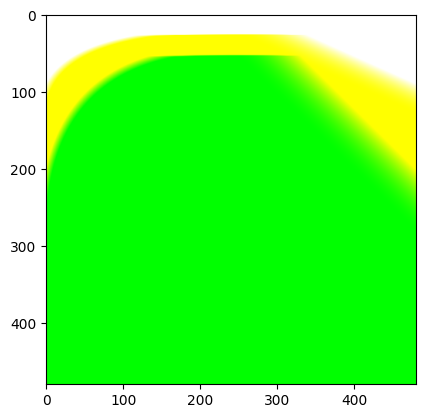

In [11]:
import grn
import numpy as np
import matplotlib.pyplot as plt


g = grn.GRN()
nin = 2
nout = 3
nreg = 1
g.random(nin=nin, nout=nout, nreg=2)

N = 480


matrix = np.zeros((N,N,3))
g.step(25)
for i in range(N):
    for j in range(N):
        g.set_input([i/N, j/N])
        g.step()   
        out = g.get_output()
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(np.max(matrix))
plt.imshow(matrix*10)

print(out)
# plt.savefig("test.png")

[1, 1, 1, 1.7613586175162352, 1.5792348001641545, 0, 0, 1, 0.5683822373597186, 0.3442162087768753, 0.505713153943958, 0.1807776639321993, 0.5748988316567222, 0.5859445136213363, 0.16449191822988762, 0.1339060473334328, 0.12339962802676341]


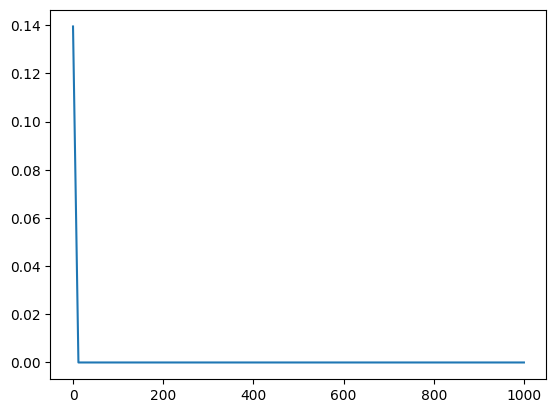

In [17]:
from grn import GRN
import matplotlib.pyplot as plt 
g = GRN(nin=1, nout=1, nreg=1, a=0, f=0)

print(g.genome)
g.reset()

g.step(nsteps=25)

outputs = []
outputs.append(g.get_output())


for i in range(1000):
    # g.set_input([0.5, 0.5])
    g.set_input([0.1])
    g.step()
    outputs.append(g.get_output())
    # print(g.concentrations)

plt.plot(outputs)

In [ ]:
print("grn concentrations summ should be  1 : ", np.sum(g.concentrations[nin:]))
print("grn concentrations ", g.concentrations)
print("grn genome ", g.genome)
print("len genome ",len(g.genome))


In [ ]:
# verify if step is working well 

In [ ]:
str(g)

tg = grn.GRN()
tg.from_genome(g.genome)


In [14]:
import cma
from grn import GRN
import problem as p
import numpy as np
from loguru import logger
# from cma.utilities.utils import BoundTransform

xtrain = np.linspace(0, 1, 100)
ytrain = np.sin(xtrain)**2

problem = p.RegressionProblem(xtrain, ytrain)

n_reg = 0
n_in = 1
n_out = 1

# get random genome
g = GRN()

x0 = g.random(nin=n_in, nout=n_out, nreg=n_reg)
x0 = np.delete(x0, [0,1,2,5,6,7])
x0 = transform_genome(x0)
fit0 = problem.eval(x0)

logger.info(f"intial fit: {fit0}")

# cma_option = {
#         'tolfun': 1e-20,  # Effectively disable fitness tolerance
#         'verb_filenameprefix': 'out/cmaes/',
#         # 'max_iter': 100,   # Force CMA-ES to run for 100 generations
#     }
# # # run cma
# cma_result = cma.fmin(problem.eval, x0, 0.1, cma_option)
upper = [2.0, 2.0,]
lower = [0.2, 0.2,]
for i in range(3*(g.nreg  + g.nin + g.nout)):
    lower.append(0.0)
    upper.append(1.0)
bounds = [lower, upper]
    
print(bounds)
CMA_OPTIONS = {
        'bounds': bounds,
        'popsize': 500,
        'tolfun': 1e-20,
        'maxiter': 1000,
        'seed': 447883,
        'CMA_elitist': True,   
        'maxiter': 500,  # Force generations per restart
        # 'verb_filenameprefix': 'out/cmaes/',
    }


es = cma.CMAEvolutionStrategy(x0, 1, CMA_OPTIONS)
es = es.optimize(problem.eval)


NameError: name 'transform_genome' is not defined

In [ ]:
es.stop()

In [ ]:
import matplotlib.pyplot as plt 

tg = GRN()
g.reset()

tg.from_genome(g.genome)
tg.from_genome_cmaes(es.best.x)
# tg.random(nin=n_in, nout=n_out, nreg=10)
print(es.best.x)

yg = problem.run_grn(g)
ytg = problem.run_grn(tg)
# ytg = problem.run_grn(r)
# problem.run_grn(g)
plt.plot(xtrain, yg, label="grn")
plt.plot(xtrain, ytg, label="tg")
plt.plot(xtrain, ytrain, label = "target")

err = np.linalg.norm(ytrain - np.array(ytg))
print("err", err)
plt.legend()
# g.from_genome_cmaes(cma_result[0])
# print(tg)
# print("best grn fit: ", problem.run_grn(tg.genome))

In [ ]:
import random
from deap import base, creator, tools, algorithms

# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # Gene: random float in [0, 1]
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=5  # Genome length = 5
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    return sum(individual),

# 3. Define genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover (blend parents)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up = 1.0, indpb=0.1)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

# 4. Create population and run the GA
population = toolbox.population(n=50)  # 50 individuals
algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.0,       # Crossover probability
    mutpb=0.2,      # Mutation probability
    ngen=100,        # Generations
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=1)[0]
print(f"\nBest genome: {best_individual}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")

/home/jmartinsaquet/.pyenv/versions/smartdart3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/jmartinsaquet/.pyenv/versions/smartdart3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max     
0  	1000  	-58.0976	-67.6821	-39.0963
1  	1000  	-50.4339	-67.6821	-39.0963
2  	1000  	-46.5437	-63.8997	-35.2097
3  	1000  	-44.5815	-67.6821	-35.2097
4  	1000  	-43.147 	-65.6412	-34.4702
5  	1000  	-41.7873	-67.5824	-34.4702
6  	1000  	-40.7362	-65.887 	-34.3572
7  	1000  	-39.4383	-65.9348	-34.1206
8  	1000  	-38.6261	-65.9916	-34.1206
9  	1000  	-38.1314	-67.6821	-33.9308
10 	1000  	-37.8634	-64.0725	-33.4306
11 	1000  	-37.6595	-67.6821	-33.4306
12 	1000  	-37.9532	-67.0259	-33.4301
13 	1000  	-37.3703	-65.2805	-33.4301
14 	1000  	-37.6372	-67.5015	-33.4258
15 	1000  	-36.835 	-67.6788	-33.4174
16 	1000  	-36.7485	-67.6821	-33.4151
17 	1000  	-36.3415	-67.5373	-33.3425
18 	1000  	-36.9396	-67.2204	-33.3671
19 	1000  	-36.8468	-67.6821	-33.3671
20 	1000  	-36.9772	-67.6821	-33.3671
21 	1000  	-37.1151	-67.6821	-33.3671
22 	1000  	-37.6875	-67.6821	-33.3671
23 	1000  	-37.0621	-67.6821	-33.3658
24 	1000  	-36.8547	-67.6821	-33.3335
25 	1000  	-

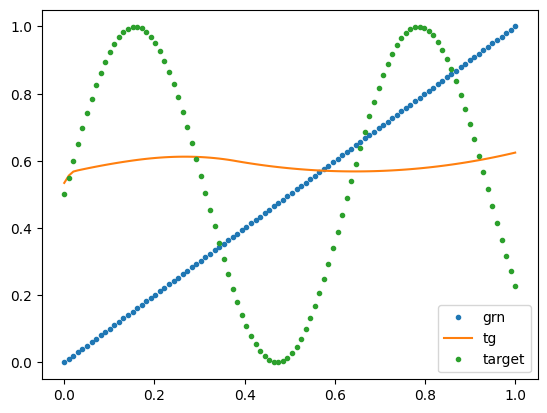

In [4]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from grn import GRN
import problem as p 
import matplotlib.pyplot as plt


# grn hyperparameters 
global nin, nout, nreg, a, f
nin = 1
nout = 1
nreg = 10

a = 1
f = 1

size = nin + nout + nreg
genome_size = size*3 + 2 # 2 for beta and delta

# create the problem instance 
t = np.linspace(0, 1, 100)
xtrain = t
# ytrain = np.sin(xtrain)**2  * 0
ytrain = np.sin(t*10)/2 + 1/2

global problem
problem = p.RegressionProblem(xtrain, ytrain)

def transform_genome(genome):
    new_genome = genome.copy()
    # reconstruct the genome to be grn compatible with 
    new_genome.insert(0, nin)
    new_genome.insert(1, nout)
    new_genome.insert(2, nreg)
    new_genome.insert(5, a)
    new_genome.insert(6, f)
    new_genome.insert(7, 1.0)
    # print("new genome ", new_genome[3:5])
    new_genome[3:5] = (1.80*np.array(new_genome[3:5]) + 0.2).tolist()
    return new_genome


def evaluate(individual):

    grn_genome = transform_genome(individual)
    # grn_genome = individual.copy()

    return problem.eval(grn_genome),
# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # Gene: random float in [0, 1]
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=genome_size  
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



# 3. Define genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover (blend parents)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=10.0, low=0.0, up = 1.0, indpb=0.01)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

population = toolbox.population(n=1000)  # 50 individuals
hof = tools.HallOfFame(1)  # Track best individual

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_fit.register("avg", np.mean)
stats_fit.register("min", np.min)
stats_fit.register("max", np.max)


algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.0,       # Crossover probability
    mutpb=1.0,      # Mutation probability
    ngen=200,        # Generations
    halloffame=hof,
    stats=stats_fit,
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=1)[0]
print(f"\nBest genome: {best_individual}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")

tg = GRN()
g = GRN()
# tg.from_genome(g.genome)
tg.from_genome(transform_genome(best_individual))

# tg.random(nin=n_in, nout=n_out, nreg=10)
# print(es.best.x)

yg = problem.run_grn(g)
ytg = problem.run_grn(tg)
# ytg = problem.run_grn(r)
# problem.run_grn(g)
plt.plot(t, xtrain, '.', label="grn")
plt.plot(t, ytg, '-', label="tg")
plt.plot(t, ytrain, '.', label = "target")

plt.legend()

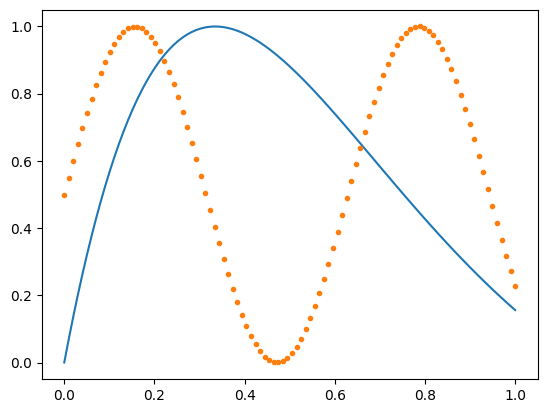

In [5]:
# plt.plot(t, np.array(ytg)*10, '-', label="tg")

ytg = (np.array(ytg) - np.min(ytg))/(np.max(ytg) - np.min(ytg))
ytrain = np.array(ytrain)

plt.plot(t, np.array(ytg) * (np.max(ytrain) - np.min(ytrain)) + np.min(ytrain), '-', label="tg")
plt.plot(t, ytrain, '.', label = "target")

In [2]:
import numpy as np
from grn import GRN
import matplotlib.pyplot as plt


g = GRN()

g.random(nin=1, nout=1, nreg=3)
print("random enhance match", g.enh_afinity_matrix)
# grn evolved with great from pygnr should looks like a square 
g.beta = 0.9116682507312829
g.delta = 1.8735
g.identifiers = [0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]
g.enhancers = [0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]
g.inhibiters = [0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009]
g.a = 0
g.f = 0


t = np.linspace(-1, 1, 500)

g.setup()

print(g.concentrations)
g.warmup(25)
print(g.size)
print("concentration after warmup", g.concentrations)
# ys = []
# for ti in t:
#     g.set_input([ti])
#     g.step()
#     ys.append(g.get_output())


# plt.plot(t, ys, label="evolved")
# # plt.plot(t, ytrain, '.', label = "target")
# plt.legend()

# print(g)
# print("enh matrix ", g.enh_afinity_matrix)
# print("inh matrix shape ", g.inh_affinity_matrix)

random enhance match [[0.32965372 0.40776989 0.62284634 0.29058935 0.25414351]
 [0.39192693 0.31684579 0.20743507 0.44461428 0.50837487]
 [0.33070642 0.26735325 0.19155714 0.3751638  0.42896474]
 [0.19878321 0.24588774 0.37558015 0.19134479 0.21878489]
 [0.2545529  0.20578839 0.24886449 0.28877284 0.33018475]]
[0.2 0.2 0.2 0.2 0.2]
5
concentration after warmup [0.         0.35816735 0.         0.         0.68689872]
